In [115]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl 
import pyagrum.causal.notebook as cslnb

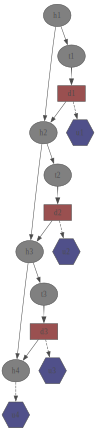

In [ ]:
pigs = gum.InfluenceDiagram()
pigs.loadBIFXML('.\pigs_limid.bifxml')
gnb.showInfluenceDiagram(pigs)

In [117]:
def IDToBN(id: gum.InfluenceDiagram) -> gum.BayesNet:
    '''
    Description: 
    Converts an influence diagram to a bayesian diagram with the same structure.

    Arguments:
    id : gum.InfluenceDiagram

    Returns: 
    res : gum.BayesNet
    '''
    v = len(id.nodes()) # number of vertices in the graph
    res = gum.BayesNet()
    for i in range(v):  # copy nodes over
        res.add(gum.LabelizedVariable(str(i)))
    for src, dst in id.arcs():  # copy arcs over
        res.addArc(str(src), str(dst))
    return res


In [118]:
def getDecisionNodes(id):
    ''' 
    Get all decision nodes in IDs.

    Returns a generator with all the decision nodes.
    '''
    for node in id.nodes():
        if id.isDecisionNode(node):
            yield node

In [119]:
def getRelU(id, decisionSet : set[int]):
    '''
    Description:
    Get generator of relevant utility nodes to decisionSet in the ID

    Arguments:
    id : gum.InfluenceDiagram
    decisionSet : set[int]
    '''
    for u in set().union(*[id.descendants(i) for i in decisionSet]):
        if id.isUtilityNode(u):
            yield u

In [120]:
def decisionOrder(id):
    ''' 
    innate pygrum method not working, workaround
    '''
    res = id.topologicalOrder()[::-1] # reverse topological order
    return list(filter(lambda x : id.isDecisionNode(x), res))

In [ ]:
def backdoorBetweenSets(bn: gum.BayesNet, causeSet: set[int], effectSet: set[int], notBD: set[int]=None):
    if not_bd is None:
        not_bd = set()
    
    all_backdoors = set()
    
    for cause in causeSet: 
        for effect in effectSet:
            backdoors = csl.backdoor_generator(bn, cause, effect, not_bd)
            if backdoors:  # just the non empty bds
                for b in backdoors:
                    all_backdoors.add(*b)
                
    return all_backdoors

In [152]:
def blocksAllBackDoorPaths(bn: gum.BayesNet, causeSet: set[int], effectSet: set[int], bd: set[int]):
    aux = gum.BayesNet(bn)
    for b in bd:
        aux.erase(b)
    return backdoorBetweenSets(aux, causeSet, effectSet) == set()


In [161]:
def getRelO(id: gum.InfluenceDiagram, decisionSet: set[int]):
    relu = list(getRelU(id, decisionSet))
    bayesNet = IDToBN(id)
    parents = set().union(*[id.parents(d) for d in decisionSet])
    backDoor = backdoorBetweenSets(bayesNet, decisionSet, relu) & parents
    init = list(backDoor)
    for b in init:
        if blocksAllBackDoorPaths(bayesNet, decisionSet, relu, backDoor - {b}):
            backDoor.remove(b)
    return backDoor
    

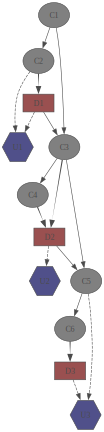

In [124]:
figure2 = gum.InfluenceDiagram()
figure2.loadBIFXML('figure_2.bifxml')
gnb.showInfluenceDiagram(figure2)
figure2Causal = csl.CausalModel(IDToBN(figure2))

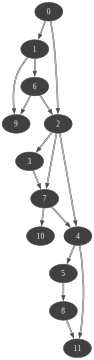

In [127]:
cslnb.showCausalModel(figure2Causal, 5)

In [163]:
getRelO(figure2, {8})

{5}

In [ ]:
blocksAllBackDoorPaths(IDToBN(figure2), {7, 8}, list(getRelU(figure2, {7, 8})), {2, 3, 5})

False

In [166]:
getRelO(pigs, {9})

{6}

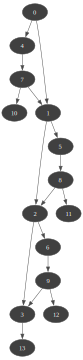

In [165]:
pigsBN = IDToBN(pigs)
gnb.showBN(pigsBN)